In [7]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [34]:
def get_frequencies(target_pubmed_id):
    all_mesh_terms = []
    with open('ourdat/citations_small200.TiAbMe') as citations_info:
        try:
            while(True):
                line = next(citations_info).strip()
                pubmed_id, _, num_cited = line.split("|")
                num_cited = int(num_cited)
                for _ in range(num_cited):
                    _ = next(citations_info) # original
                    _ = next(citations_info) # title
                    _ = next(citations_info) # abstract
                    mesh_terms = next(citations_info).strip().split('|')[2:]
                    if pubmed_id == target_pubmed_id:
                        terms = set()
                        for term in mesh_terms:
                            if term == '': continue
                            cleaned_up_term = term.split(',')[0].split('!')[0].split('*')[0]
                            terms.add(cleaned_up_term.lower())
                        all_mesh_terms += list(terms)

        except StopIteration:
            pass

    mesh_term_frequencies = Counter(all_mesh_terms)
    frequencies = list(mesh_term_frequencies.items())
    return frequencies

In [35]:
def get_mesh_terms(target_pubmed_id):
    with open('paperdat/SMALL200/S200.TiAbMe') as info_file:
        for line in info_file:
            record = line.split('|')
            if record[0] != target_pubmed_id: continue
            if record[1] != 'm': continue
            
            mesh_terms = record[2:]
            terms = set()
            for term in mesh_terms:
                term = term.strip()
                if term == '': continue
                cleaned_up_term = term.split(',')[0].split('!')[0].split('*')[0]
                terms.add(cleaned_up_term.lower())
            return list(terms)

In [36]:
def show_wordcloud(pubmed_id):
    plt.figure(figsize = (8,6))
    wordcloud = WordCloud().fit_words(get_frequencies(pubmed_id))
    plt.imshow(wordcloud, aspect='auto')
    plt.axis("off")
    print(get_mesh_terms(pubmed_id))

['ras proteins', 'receptors', 'signal transduction', 'enzyme activation', 'protein-serine-threonine kinases', 'sos1 protein', 'arabidopsis proteins', 'cells', 'ras guanine nucleotide exchange factors', 'ras-grf1', 'extracellular signal-regulated map kinases', 'stroke', 'neurons', 'mice', 'animals', 'cyclic amp response element-binding protein']


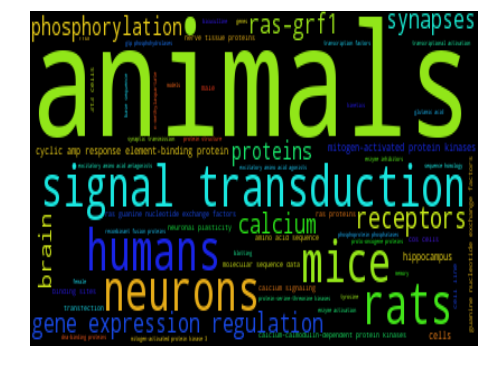

In [37]:
show_wordcloud('15029245')

['gene expression regulation', 'amino acid sequence', 'yeasts', 'sequence alignment', 'arabidopsis proteins', 'cell division', 'sequence analysis', 'plant roots', 'phylogeny', 'molecular sequence data', 'transcription factors', 'arabidopsis']


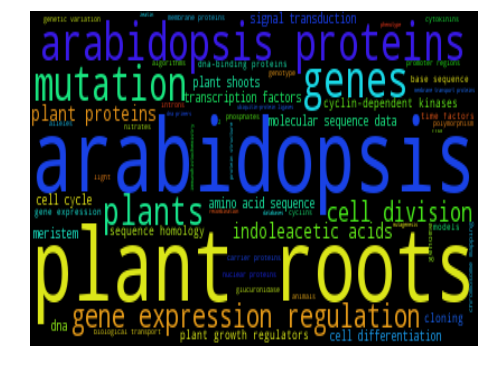

In [39]:
show_wordcloud('15031265')

['embryo', 'receptors', 'mice', 'protease inhibitors', 'fibrin', 'dipeptides', 'male', 'neovascularization', 'embryo loss', 'plasminogen activators', 'in situ hybridization', 'embryo implantation', 'placentation', 'pregnancy', 'matrix metalloproteinases', 'plasminogen', 'animals', 'female', 'placenta']


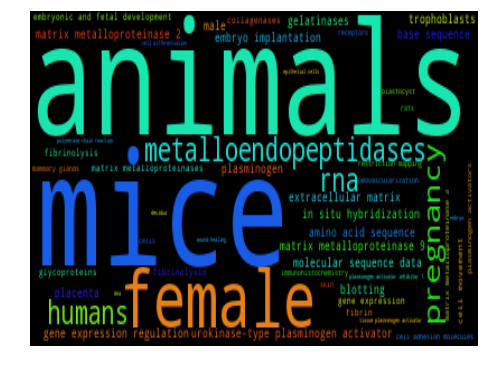

In [40]:
show_wordcloud('12900459')